# This model was created following the tutorial here: 
https://github.com/tensorflow/examples/blob/master/community/en/transformer_chatbot.ipynb

Accompanying Medium article: https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2

Original paper: https://arxiv.org/pdf/1706.03762.pdf


Further info on Transformers: https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04

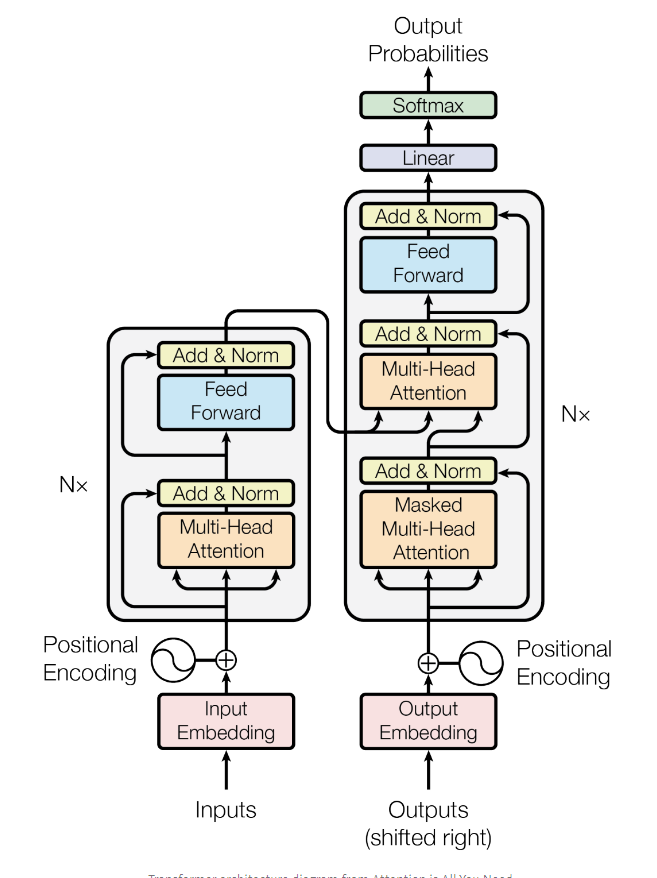


Notes to go back to:
*   achieve peak performance that delivers data for next step before current step has finished 
*  teacher forcing; pass true output to next time step regardless of what the model predicts at current time step 
* uses self-attention to look at previous words in the input sequence to better predict the next word 
* uses a look-ahead mask to prevent model from peaking at the expected output
* target divided into decoder_inputs and is padded as an input to the decoder
* cropped_targets for calculating loss accuracy 


In [1]:
import tensorflow as tf
# assert tf.__version__.startswith('2')
# tf.random.set_seed(1234)

# !pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, Dropout, Flatten, Bidirectional, Concatenate, Reshape, Average, Add

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

import tensorflow_hub as hub
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer
import math

Load the data

In [85]:
num_samples = 20000 # Number of samples to train on.

In [86]:
#read from dataset and split into input and targets
df = pd.read_csv("char_cleaned_data3.csv")
# df.fillna('', inplace=True)
df.dropna(subset = ["x1"], inplace=True)
df.dropna(subset = ["y1"], inplace=True)
df.head()

,x1,y1
0,what kind of phones do you guys have,i have a it is pretty great much better than w...
1,i have a it is pretty great much better than w...,does it really charge all the way in min
2,does it really charge all the way in min,pretty fast i have never it but it is under ha...
3,what kind of phones do you guys have,samsung galaxy j it is my first cell phone and...
4,samsung galaxy j it is my first cell phone and...,what do you think of it anything you do not like


In [87]:
print(len(df))
questions = df["x1"].tolist()[:num_samples]
answers = df["y1"].tolist()[:num_samples]

print(len(questions))
print(len(answers))

47365
20000
20000


In [88]:
max_seq_length = 128  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [89]:
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [90]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [91]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [122]:
def tokenize (s):
    stokens = tokenizer.tokenize(s)
    stokens =  ["[CLS]"] + stokens + ["[SEP]"]
    
    return stokens

input_ids = []
input_masks = []
input_segments = []

for line in questions:
    stokens = tokenize(line)
#     print(stokens)
    input_ids.append(get_ids(stokens, tokenizer, max_seq_length))
    input_masks.append(get_masks(stokens, max_seq_length))
    input_segments.append(get_segments(stokens, max_seq_length))

In [123]:
input_ids = np.array(input_ids)
input_masks= np.array(input_masks)
input_segments = np.array(input_segments)

In [94]:
tokens = set()
for line in questions:
    t = tokenizer.tokenize(line)
    for i in t:
        tokens.add(i)
    
tokens.add("[CLS]")
tokens.add("[SEP]")

In [95]:
tokens

{'##ally',
 'del',
 'sur',
 'painting',
 'mommy',
 '##oke',
 'lads',
 'mass',
 'insulting',
 '##le',
 'phrase',
 'gb',
 'freshman',
 'mole',
 'insight',
 'speaking',
 'ha',
 'caretaker',
 'holes',
 'error',
 '##sie',
 'enter',
 'comrade',
 'myth',
 'russia',
 'his',
 'mines',
 'opened',
 'cow',
 'surely',
 'freelance',
 'more',
 'how',
 'hidden',
 '##sca',
 'austin',
 'screwed',
 'shots',
 'ta',
 'retreated',
 'toyota',
 'forty',
 'girl',
 'former',
 'settings',
 'minutes',
 'relatively',
 'mark',
 'bathroom',
 'write',
 'zeppelin',
 'surprised',
 'magic',
 'communist',
 'condoms',
 'winter',
 'northern',
 'step',
 'even',
 'banana',
 'player',
 'teaching',
 'prevention',
 'owned',
 'nightmares',
 'woo',
 'soldiers',
 'bragg',
 'sing',
 'ghost',
 '##ff',
 'listener',
 'tour',
 'moderator',
 'over',
 'row',
 'mature',
 'consecutive',
 'hilarious',
 'date',
 'swiss',
 'filipino',
 'generate',
 'confident',
 'ought',
 'fishing',
 'insert',
 'making',
 'yellow',
 'image',
 'senior',
 'prov

Build a tokenizer for the total vocabulary in the inputs and outputs. 
*   We tokenize data by assigning words (the tokens) to labels (numbers)
*  Subword Text Encoder takes unknown vocab and tokenizes it individually as well



In [114]:
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     questions + answers, target_vocab_size=2**13)

In [115]:
# #define start and end tokens to be the last two in tokenizer
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# # Vocabulary size plus start and end token
# VOCAB_SIZE = tokenizer.vocab_size + 2

In [116]:
# # Maximum sentence length
# MAX_LENGTH = 40

# # Tokenize, filter and pad sentences
# def tokenize_and_filter(inputs, outputs):
#   tokenized_inputs, tokenized_outputs = [], []
  
#   for (sentence1, sentence2) in zip(inputs, outputs):
#     # tokenize sentence
#     sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
#     sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
#     # check tokenized sentence max length
#     if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#       tokenized_inputs.append(sentence1)
#       tokenized_outputs.append(sentence2)
  
#   # pad tokenized sentences
#   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
#   return tokenized_inputs, tokenized_outputs


# questions, answers = tokenize_and_filter(questions, answers)

Use a dataset api to construct the input pipeline. 

In [118]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 20000

# # decoder inputs use the previous target as input
# # remove START_TOKEN from targets
# dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'inputs': questions,
#         'dec_inputs': answers[:, :-1]
#     },
#     {
#         'outputs': answers[:, 1:]
#     },
# ))

# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

Attention can be described as mapping a query and a set of key-value pairs to an output. Output is the weighted sum of the values, where the weight assigned to each value is computed by a function of the query with the corresponding key. 

Scaled dot product attention takes 3 inputs: query, key, value.
Softmax normalization is done on a key, and the values decide the importance given to the query.

The output is a multiplication of a weights and value, which allows us to emphasize the words that are important, and put less emphasis on the irrelevant ones. 

A query is a vector representation of one word in a sentence.
A key is a vector representation of all the words in a sentence.
A value is a vector representation of the words in a sentence, after multiplication and summing with attention weights. 

A mask is multiplied by a number close to neg infin because it is summed with the previous multiplication ouput and applied before softmax. We want to zero out the cells, where a large neg input is near zero in the output. 

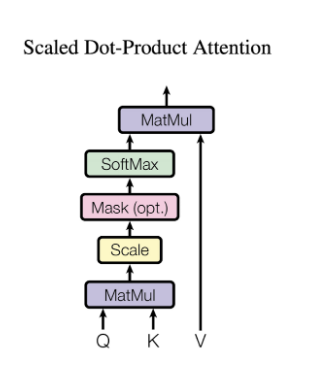

In [96]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9) #close to -infinity

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

MultiHeadAttention takes 3 inputs (q, k, v) which is gotten from splitting it through a Dense  (linear) layer. The input values then go through multiple scaled dot product attention layers, concatenated again, then put through a final linear layer. 

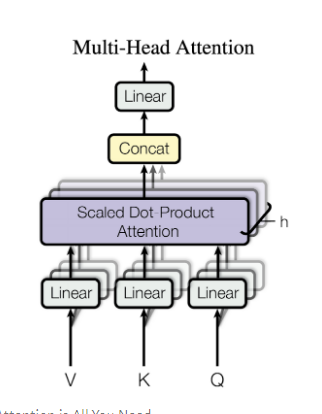

In [97]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # concatenation of heads(attention)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

Create padding mask puts 1s where the zeros occur. 

In [98]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

Look ahead mask masks future tokens (eg. we can predict the thid word only needing the first and second). 

linalg.band_part takes an input, num_lower, num_upper (-1,0) and takes the lower triangular part. 

In [99]:
#look ahead mask masks future tokens (i.e to predict the third word we only need the first and second)
#linalg.band.part takes input, num_lower, num_upper(-1, 0) and takes the lower triangular part 
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

Positional encoding is used to give model the relative position of words in a sentence, since there are no CNNs or RNNs. An embedding only gives information where tokens with similar meaning are closer together. 
We add the positional encoding to the embeddeding to give information about both. 

In [100]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [101]:
# #each encoder layer consists of: multi-head attention(with padding mask), 2 dense layers with dropout
# def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
#     inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#     attention = MultiHeadAttention(
#       d_model, num_heads, name="attention")({
#           'query': inputs,
#           'key': inputs,
#           'value': inputs,
#           'mask': padding_mask
#       })
#     attention = tf.keras.layers.Dropout(rate=dropout)(attention)
#     attention = tf.keras.layers.LayerNormalization(
#         epsilon=1e-6)(inputs + attention)

#     outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
#     outputs = tf.keras.layers.Dense(units=d_model)(outputs)
#     outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#     outputs = tf.keras.layers.LayerNormalization(
#         epsilon=1e-6)(attention + outputs)

#     return tf.keras.Model(
#           inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [125]:
# #each encoder has an: input embedding, positional encoding, num_layers encoder layers
# #embedding is summed with positional encoding, and then is passed to encoder layers 
# #output of encoder goes to decoder

# def encoder(vocab_size,
#             num_layers,
#             units,
#             d_model,
#             num_heads,
#             dropout,
#             name="encoder"):
#     inputs = tf.keras.Input(shape=(None,), name="inputs")
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#     embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#     embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
#     embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

#     outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#     for i in range(num_layers):
#         outputs = encoder_layer(
#             units=units,
#             d_model=d_model,
#             num_heads=num_heads,
#             dropout=dropout,
#             name="encoder_layer_{}".format(i),
#         )([outputs, padding_mask])

#     return tf.keras.Model(
#         inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [102]:
#each decoder layer has: masked multi-head attention(with look ahead and padding mask),
#multi-head attention(w/ padding mask) where the value and key receive the encoder output as inputs, query receives the output from the masked multi-head attenion
#2 dense layers with dropout

#the decoder predicts the next word by looking at the encoder output and self-attending to its own output
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [103]:
#each decoder has an: output embedding, positional encoding, n decoder layers 
#output of decoder is input to final linear layer 

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [104]:
#lambda layer is an arbitrary layer so tensorflow functions can be used to create models 
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
#     #encoder inputs 
#     inputs = tf.keras.Input(shape=(max_seq_length, ), name="inputs")
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
    
    inputs = [input_word_ids, input_mask, segment_ids]
    
    #decoder inputs 
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
#     #create padding mask for encoder inputs 
#     enc_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None),
#       name='enc_padding_mask')(inputs)

    #decoder padding masks:
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)
#     ([[input_ids],[input_masks],[input_segments]])

#   #encoder 
#     enc_outputs = encoder(
#       vocab_size=vocab_size,
#       num_layers=num_layers,
#       units=units,
#       d_model=d_model,
#       num_heads=num_heads,
#       dropout=dropout,
#     )(inputs=[inputs, enc_padding_mask])
    pooled_output, sequence_output = bert_layer(inputs)
    
    pooled_output = tf.reshape(pooled_output, (-1, -1, 256))
    sequence_output = tf.reshape(sequence_output, (-1, 1, -1, -1))
    
    enc_outputs = [pooled_output, sequence_output]
    
  #decoder 
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [69]:
# pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [63]:
# pooled_output.shape

TensorShape([None, 768])

In [70]:
#  sequence_output.shape

TensorShape([None, None, 768])

In [71]:
# tf.reshape(sequence_output, (-1, 1, -1, -1))

<tf.Tensor 'Reshape_1:0' shape=(None, 1, None, None) dtype=float32>

In [105]:
tf.keras.backend.clear_session()
VOCAB_SIZE = len(tokens)

# Hyper-parameters
NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2 #changed Dropout to 0.2

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [106]:
#since target sequences are padded, we apply a padding mask when calculating loss
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [107]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [108]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [126]:
print(input_ids.shape)
print(input_masks.shape)
print(input_segments.shape)

(20000, 128)
(20000, 128)
(20000, 128)


In [113]:
# tf.reshape(input_ids, (128))

In [128]:
model.predict( [input_ids, input_masks, input_segments])

AssertionError: in user code:

    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\training.py:1084 predict_function  *
        outputs = self.distribute_strategy.run(
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\training.py:1059 predict_step  **
        return self(x, training=False)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\network.py:712 call
        return self._run_internal_graph(
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\network.py:894 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("outputs/Identity:0", shape=(None, None, 5972), dtype=float32)


In [127]:
# EPOCHS =10
# model.fit( [input_ids, input_masks, input_segments], epochs=EPOCHS)

Epoch 1/10


AssertionError: in user code:

    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\training.py:505 train_function  *
        outputs = self.distribute_strategy.run(
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\training.py:465 train_step  **
        y_pred = self(x, training=True)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\network.py:712 call
        return self._run_internal_graph(
    c:\users\charm\my_env\lib\site-packages\tensorflow\python\keras\engine\network.py:894 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("outputs/Identity:0", shape=(None, None, 5972), dtype=float32)


In [0]:
# model.save('transformer.h5')

We tokenize the input and populate it with the start and end tokens. We calculate the padding and look ahead masks. The decoder outputs predictions by looking at the output of the encoder and its own output. Select the last word and calculate the argmax of that (class with largest predicted probability ?). 

The decoder predicts the next word based on the previous words it predicted by concatenating the predicted word to the decoder input. 

In [134]:
def evaluate(sentence):
  # sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [135]:
output = predict("what is good")

Input: what is good
Output: the only good thing u guys have are german


In [0]:
# line = "what is good"
# print (tokenizer.encode(line))

# line = tf.expand_dims(START_TOKEN + tokenizer.encode(line) + END_TOKEN, axis=0)
# output = tf.expand_dims(START_TOKEN, 0)
# print (line)
# print (output)

In [0]:
  # for i in range(MAX_LENGTH):
  #   predictions = model(inputs=[line, output], training=False)
  #   predictions = predictions[:, -1:, :]
  #   print (predictions)
  #   predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
  #   print (predicted_id)

  #   if tf.equal(predicted_id, END_TOKEN[0]):
  #       break
  #   output = tf.concat([output, predicted_id], axis=-1)
  #   print (output)

In [0]:
# p = tf.squeeze(output, axis=0)
# print (p)

In [0]:
# predicted_sentence = tokenizer.decode(
#   [i for i in p if i < tokenizer.vocab_size])

# predicted_sentence

In [137]:
text=[]
with open('testing.csv', mode='r') as f: 
  for line in f:
    text.append(line)

for line in text:
    sentence = predict(line)
    print ('')

Input: ï»¿i am an amazon warrior it means i shop on amazon a lot

Output: you are a part of the drinking age and a week like a lot

Input: how are you doing today

Output: i am not sure if that is how i feel hours drunk here

Input: i do not like you because of your face

Output: no but i have data

Input: what do you think about trump

Output: it is so

Input: i suppose you are smart can you make me a sandwich

Output: i am not even sure if our music is still onlinethank you

Input: can you do math on your own

Output: i have never had a girlfriend

Input: so i got a girlfriend today

Output: that is not a productive meeting then

Input: what kind of pizza do you like

Output: i am not sure if that is how i feel hours drunk haha

Input: i am working on a website project 

Output: i am not sure what is few fuck up how is your life going

Input: do you like chem homework

Output: thanks for understanding and not for the moment

Input: i ate leftover pizza from yesterday it taste bad

Ou